# Feature Engineering
Reference: https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author/notebook

Dataset: https://www.kaggle.com/c/spooky-author-identification/data

In [1]:
import string
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')

import xgboost as xgb
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Dataset

In [2]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')

In [3]:
train_df.shape

(19579, 3)

In [4]:
test_df.shape

(8392, 2)

In [5]:
train_df.shape[0] / test_df.shape[0]

2.3330552907530984

In [6]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
cnt_srs = train_df['author'].value_counts()

In [8]:
type(cnt_srs)

pandas.core.series.Series

In [9]:
cnt_srs.head()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

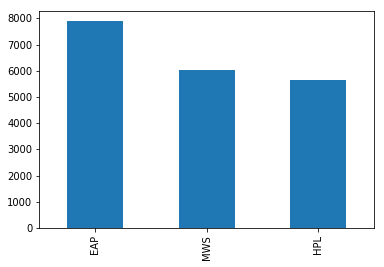

In [10]:
train_df['author'].value_counts().plot.bar()

### Observation
The class imbalance is not severe. However, it can be fixed by hyperparameters of XGBoost, i.e. scale_pos_weight.

# Print First 5 Documents of Each Author

In [11]:
grouped_df = train_df.groupby('author')

In [12]:
type(grouped_df)

pandas.core.groupby.generic.DataFrameGroupBy

In [13]:
for name, group in grouped_df:
    print('Author: {}'.format(name))
    
    cnt = 0
    
    for index, row in group.iterrows():
        print('index {}:\n\t{}'.format(index, row['text']))
        cnt += 1
        
        if cnt > 5:
            break
            
    print()

Author: EAP
index 0:
	This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
index 2:
	In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
index 6:
	The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
index 7:
	The surcingle hung in ribands from my body.
index 8:
	I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the l

# Feature Engineering:
- Meta Features
    - Features that are extracted from the text like number of words, stopwords, and punctuations.
        1. Number of words.
        - Number of unique words.
        - Number of characters.
        - Number of stopwords.
        - Number of punctuations.
        - Number of upper case words.
        - Number of title case words.
        - Average length of words.
- Text-Based Features
    - Word frequency (BOW or TF-IDF), SVD, word2vec, etc.

### Number of words

In [14]:
type(train_df['text'][:5])

pandas.core.series.Series

In [15]:
train_df['text'][1]

'It never once occurred to me that the fumbling might be a mere mistake.'

In [16]:
train_df['text'][:5].map(lambda doc: len(str(doc).split(' ')))

0    41
1    14
2    36
3    34
4    27
Name: text, dtype: int64

In [17]:
train_df['num_words'] = train_df['text'].map(lambda doc: len(str(doc).split(' ')))
test_df['num_words'] = test_df['text'].map(lambda doc: len(str(doc).split(' ')))

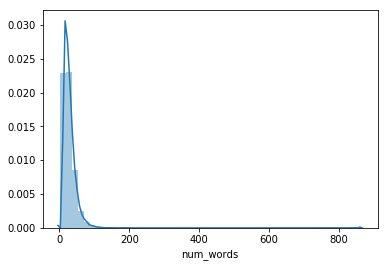

In [18]:
sns.distplot(train_df['num_words'])

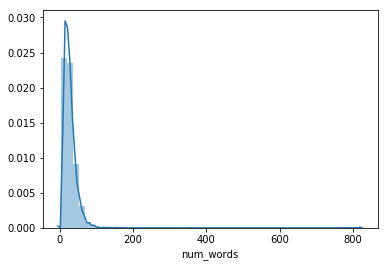

In [19]:
sns.distplot(test_df['num_words'])

# Number of unique words

In [20]:
f = lambda doc: len(set(str(doc).split(' ')))
train_df['text'][:5].map(f)

0    35
1    14
2    32
3    32
4    25
Name: text, dtype: int64

In [21]:
train_df['text'][4]

'Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.'

In [22]:
new_column_name = 'num_unique_words'

f = lambda doc: len(set(str(doc).split(' ')))

train_df[new_column_name] = train_df['text'].map(f)
test_df[new_column_name] = test_df['text'].map(f)

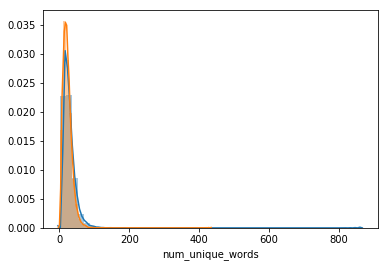

In [23]:
sns.distplot(train_df['num_words'])
sns.distplot(train_df['num_unique_words'])

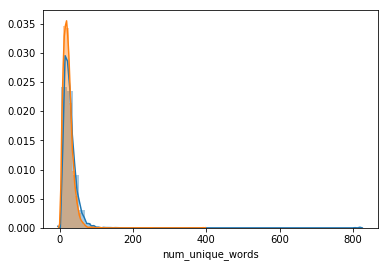

In [24]:
sns.distplot(test_df['num_words'])
sns.distplot(test_df['num_unique_words'])

# Number of Characters

In [25]:
f = lambda doc: len(str(doc))

train_df['text'][:5].map(f)

0    231
1     71
2    200
3    206
4    174
Name: text, dtype: int64

In [26]:
new_column_name = 'num_chars'
train_df[new_column_name] = train_df['text'].map(f)
test_df[new_column_name] = test_df['text'].map(f)

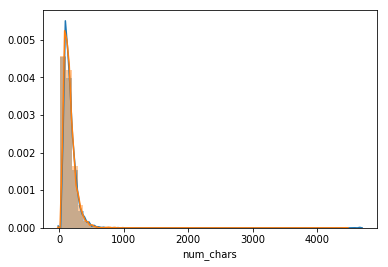

In [27]:
sns.distplot(train_df[new_column_name])
sns.distplot(test_df[new_column_name])

# Number of Stopwords

In [28]:
eng_stopwords = nltk.corpus.stopwords.words('english')

In [29]:
len(eng_stopwords)

179

In [30]:
print(eng_stopwords[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [31]:
f = lambda doc: len([w for w in str(doc).lower().split(' ') if w in eng_stopwords])

train_df['text'][:5].map(f)

0    19
1     8
2    16
3    13
4    11
Name: text, dtype: int64

In [32]:
train_df['text'][1]

'It never once occurred to me that the fumbling might be a mere mistake.'

In [33]:
for w in train_df['text'][1].lower().split(' '):
    if w in eng_stopwords:
        print(w)

it
once
to
me
that
the
be
a


In [34]:
f = lambda doc: len([w for w in str(doc).lower().split(' ') if w in eng_stopwords])

new_column_name = 'num_stopwords'
train_df[new_column_name] = train_df['text'].apply(f)
test_df[new_column_name] = test_df['text'].map(f)

# Number of punctuations

In [35]:
f = lambda doc: len([c for c in str(doc) if c in string.punctuation])

train_df['text'][:5].map(f)

0    7
1    1
2    5
3    4
4    4
Name: text, dtype: int64

In [36]:
train_df['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [37]:
new_column_name = 'num_punctuations'
f = lambda doc: len([c for c in str(doc) if c in string.punctuation])

train_df[new_column_name] = train_df['text'].apply(f)
test_df[new_column_name] = test_df['text'].map(f)

# Number of upper case words

In [38]:
f = lambda doc: len([w for w in str(doc).split(' ') if w.isupper()])
train_df['text'][:5].map(f)

0    2
1    0
2    0
3    0
4    0
Name: text, dtype: int64

In [39]:
train_df['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [40]:
'I'.isupper()

True

In [41]:
new_column_name = 'num_words_upper'
f = lambda doc: len([w for w in str(doc).split(' ') if w.isupper()])

train_df[new_column_name] = train_df['text'].apply(f)
test_df[new_column_name] = test_df['text'].map(f)

# Number of title words (Capitial)

In [42]:
f = lambda x: len([w for w in str(x).split() if w.istitle()])
train_df['text'][:5].map(f)

0    3
1    1
2    1
3    4
4    2
Name: text, dtype: int64

In [43]:
train_df['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [44]:
train_df['text'][0].istitle()

False

In [45]:
new_column_name = 'num_words_title'

f = lambda x: len([w for w in str(x).split() if w.istitle()])

train_df[new_column_name] = train_df['text'].apply(f)
test_df[new_column_name] = test_df['text'].map(f)

# Average length of words

In [46]:
f = lambda doc: np.mean([len(w) for w in str(doc).split(' ')])
train_df['text'][:5].map(f)

0    4.658537
1    4.142857
2    4.583333
3    5.088235
4    5.481481
Name: text, dtype: float64

In [47]:
new_column_name = 'mean_word_len'

f = lambda doc: np.mean([len(w) for w in str(doc).split(' ')])

train_df[new_column_name] = train_df['text'].apply(f)
test_df[new_column_name] = test_df['text'].map(f)

### Plot some meta features

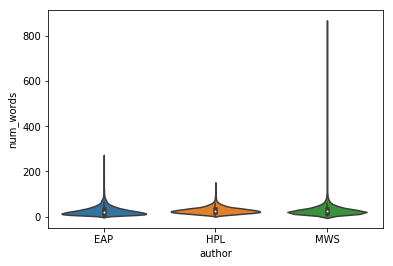

In [48]:
sns.violinplot(x='author', y='num_words', data=train_df)

### Saturate the num_words

In [49]:
df = train_df['num_words'].map(lambda num: num if num < 80 else 80)

df = pd.concat([train_df['author'], df], axis=1)

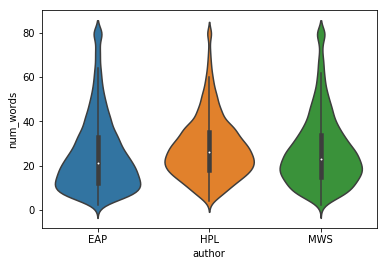

In [50]:
sns.violinplot(x='author', y='num_words', data=df)

### Plot num_punctuations

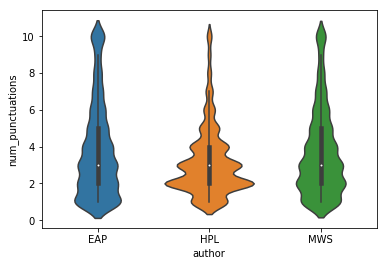

In [51]:
column_name = 'num_punctuations'
upper_bound = 10
df = train_df[column_name].map(lambda num: num if num < upper_bound else upper_bound)
df = pd.concat([train_df['author'], df], axis=1)
sns.violinplot(x='author', y=column_name, data=df)

### Plot ```num_words_title```

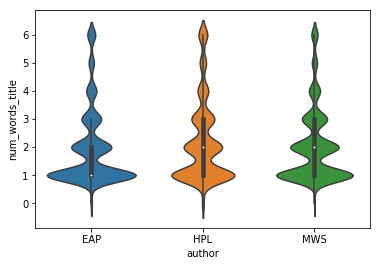

In [52]:
column_name = 'num_words_title'
upper_bound = 6
df = train_df[column_name].map(lambda num: num if num < upper_bound else upper_bound)
df = pd.concat([train_df['author'], df], axis=1)
sns.violinplot(x='author', y=column_name, data=df)

# Encode author name

In [53]:
df = train_df['author'].map({'EAP':0, 'HPL':1, 'MWS':2})

In [54]:
df[:5]

0    0
1    1
2    0
3    2
4    1
Name: author, dtype: int64

In [55]:
train_df['author'][:5]

0    EAP
1    HPL
2    EAP
3    MWS
4    HPL
Name: author, dtype: object

In [56]:
test_df.head()

,id,text,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id02310,"Still, as I urged our leaving Ireland with suc...",19,19,110,9,3,1,3,4.842105
1,id24541,"If a fire wanted fanning, it could readily be ...",62,49,330,33,7,1,3,4.338710
2,id00134,And when they had broken down the frail door t...,33,30,189,15,3,0,1,4.757576
3,id27757,While I was thinking how I should possibly man...,41,34,223,19,5,2,3,4.463415
4,id04081,I am not sure to what limit his knowledge may ...,11,11,53,6,1,1,1,3.909091


In [57]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}

train_df['author_encoded'] = train_df['author'].map(author_mapping_dict)

# Training using meta features only

In [58]:
columns_x = [ 'num_words', 'num_unique_words', 'num_chars', 
               'num_stopwords', 'num_punctuations', 'num_words_upper', 
               'num_words_title', 'mean_word_len']

column_y = 'author_encoded'

In [59]:
X_train = train_df[columns_x]
y_train = train_df[column_y]

In [60]:
X_train.head()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,41,35,231,19,7,2,3,4.658537
1,14,14,71,8,1,0,1,4.142857
2,36,32,200,16,5,0,1,4.583333
3,34,32,206,13,4,0,4,5.088235
4,27,25,174,11,4,0,2,5.481481


In [61]:
y_train.shape

(19579,)

In [62]:
model = xgb.XGBClassifier()

%time model.fit(X_train, y_train)

CPU times: user 1.75 s, sys: 11.7 ms, total: 1.76 s
Wall time: 1.77 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Generate Probability and Prediction
Reference: https://stackoverflow.com/questions/33616102/sklearn-log-loss-different-number-of-classes

In [63]:
pred = model.predict(X_train)
pred_prob = model.predict_proba(X_train)

accuracy = sklearn.metrics.accuracy_score(y_train, pred)

print()
print('Accuracy: {}'.format(accuracy))
print()
print(sklearn.metrics.classification_report(y_train, pred))



Accuracy: 0.5181572092548138

              precision    recall  f1-score   support

           0       0.51      0.75      0.61      7900
           1       0.55      0.53      0.54      5635
           2       0.47      0.20      0.28      6044

   micro avg       0.52      0.52      0.52     19579
   macro avg       0.51      0.49      0.48     19579
weighted avg       0.51      0.52      0.49     19579



In [64]:
pred.shape

(19579,)

In [65]:
pred_prob.shape

(19579, 3)

In [66]:
y_train.shape

(19579,)

In [67]:
pred[:5]

array([0, 0, 2, 1, 1])

In [68]:
pred_prob[:5]

array([[0.46104568, 0.11166213, 0.42729214],
       [0.48280507, 0.24289316, 0.27430174],
       [0.32985657, 0.3006494 , 0.36949408],
       [0.19138172, 0.635435  , 0.1731833 ],
       [0.2857823 , 0.4242329 , 0.28998482]], dtype=float32)

In [69]:
y_train[:5]

0    0
1    1
2    0
3    2
4    1
Name: author_encoded, dtype: int64

In [70]:
print()
# print(sklearn.metrics.log_loss(y_train, pred))
print(sklearn.metrics.log_loss(y_train, pred_prob))


0.9701984599282144


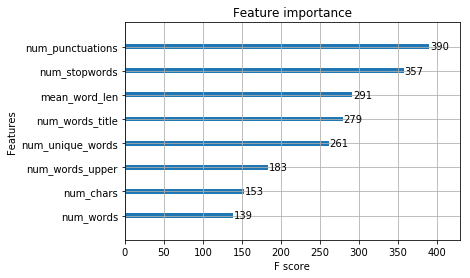

In [71]:
xgb.plot_importance(model)

### Train using DMatrix
Verify that the running time of DMatrix.
### The Key Factor of running time is ```num_boost_round```
    - To achieve the same log loss, the running time is almost the same

In [72]:
train_dm = xgb.DMatrix(X_train, label=y_train.values)

In [73]:
type(train_dm)

xgboost.core.DMatrix

In [74]:
train_dm.feature_names

['num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punctuations',
 'num_words_upper',
 'num_words_title',
 'mean_word_len']

In [75]:
param = {}
param['learning_rate'] = 0.1
param['objective'] = 'multi:softprob'
# param['eta'] = 0.1
param['max_depth'] = 3
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 1
param['colsample_bytree'] = 1
param['n_estimators'] = 100

%time model_dm = xgb.train(dtrain=train_dm, params=param, num_boost_round=100)

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.75 s


In [76]:
pred_prob = model_dm.predict(train_dm)

In [77]:
type(pred_prob)

numpy.ndarray

In [78]:
pred_prob.shape

(19579, 3)

In [79]:
pred_prob[:2]

array([[0.46104568, 0.11166215, 0.42729217],
       [0.48280507, 0.24289313, 0.2743018 ]], dtype=float32)

In [80]:
print(sklearn.metrics.log_loss(y_train, pred_prob))

0.9701984600587393


# Use K-Fold to Split Train Dataset and Increase Accuracy

In [81]:
X_train.shape

(19579, 8)

In [85]:
index = [1, 2, 5]
X_train.iloc[index, :]

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
1,14,14,71,8,1,0,1,4.142857
2,36,32,200,16,5,0,1,4.583333
5,83,66,468,43,6,5,5,4.650602


In [97]:
n_splits = 5
random_state = 2017

kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, random_state=random_state)

model = xgb.XGBClassifier()


for index_train, index_test in kf.split(X_train, y_train):
    X_train_split, y_train_split = X_train.iloc[index_train, :], y_train.iloc[index_train]
    X_test_split, y_test_split = X_train.iloc[index_test, :], y_train.iloc[index_test]
    
    model.fit(X_train_split, y_train_split)
    

In [103]:
pred = model.predict(X_train)
pred_prob = model.predict_proba(X_train)

accuracy = sklearn.metrics.accuracy_score(y_train, pred)

print()
print('Accuracy: {}'.format(accuracy))
print()

print(sklearn.metrics.classification_report(y_train, pred))

print()
print(sklearn.metrics.log_loss(y_train, pred_prob))


Accuracy: 0.5209663414883293

              precision    recall  f1-score   support

           0       0.52      0.75      0.61      7900
           1       0.55      0.54      0.55      5635
           2       0.48      0.20      0.28      6044

   micro avg       0.52      0.52      0.52     19579
   macro avg       0.52      0.50      0.48     19579
weighted avg       0.51      0.52      0.49     19579


0.9719418880085279


#### Observation
The accuracy doesn't improve.

# Generate Text-Based Features (TF-IDF)
- The size of TF-IDF vector is then reduced using SVD